In [ ]:
# !! TO MODIFY default_exp something_attention

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#hide
%load_ext autoreload
%autoreload 2

In [ ]:
#export
import torch
from torch import nn, einsum
import torch.nn.functional as F
from fastai.basics import *

from functools import partial, reduce
from inspect import isfunction
from operator import mul
from copy import deepcopy
import math
from torch import Tensor
from typing import Tuple

from einops import rearrange, repeat

from transformers_sandbox.core import *
from transformers_sandbox.layers import *
#TODO
#from transformers_sandbox.attention_core import *
from transformers_sandbox.attention import *

from torch.utils.checkpoint import *

# Attention Module Name

## Attention Projection

In [ ]:
#export
class AttnInProj(Module):
    """Computes q, k, v from input x and [optional] context"""
    def __init__(self, d_model:int, bias:bool=False):
        self.to_q = nn.Linear(d_model, d_model, bias=bias)
        self.to_k = nn.Linear(d_model, d_model, bias=bias)
        self.to_v = nn.Linear(d_model, d_model, bias=bias)
    def forward(self, x, context=None):
        context = ifnone(context, x)
        q = self.to_q(x)
        k, v = self.to_k(context), self.to_v(context)
        return q, k, v

In [ ]:
bs = 4
sl = 128
d = 64
x = torch.randn(bs, sl, d)
context = torch.randn(bs, sl-16, d)
proj = AttnInProj(d)
q1, k1, v1 = proj(x)
assert (bs, sl, d) == q1.size() == k1.size() == v1.size()
q1.shape, k1.shape, v1.shape

(torch.Size([4, 128, 64]), torch.Size([4, 128, 64]), torch.Size([4, 128, 64]))

In [ ]:
q2, k2, v2 = proj(x, context)
assert (bs, sl, d) == q2.size()
assert k2.size() == v2.size() == context.size()
assert all_equal(q1, q2)
assert not all_equal(k1, k2)
q2.shape, k2.shape, v2.shape

(torch.Size([4, 128, 64]), torch.Size([4, 112, 64]), torch.Size([4, 112, 64]))

## Scaled Dot Product Attention

In [ ]:
#export
#TODO make sure store_attention works
class ScaledDotProdAttention(Module):
    """
    Computes scaled dot-product attnetion given q, k, v
    """
    def __init__(self, d_model, n_heads, causal=False, dropout=0., shared_qk=False, store_attention:bool=False):
        store_attr()
        self.scale = (d_model//n_heads)**-0.5
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, q, k, v, attn_mask=None):
        n, device = q.size(1), q.device
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=self.n_heads), (q, k, v))
        
        # classic dot-product attention
        dots = torch.einsum('bhid,bhjd->bhij', q*self.scale, k)
        
        if exists(attn_mask):
            dots.masked_fill_(~attn_mask, MASK_VAL)
            del attn_mask            
        if self.shared_qk:
            m = torch.arange(n)   
            dots[:, :, m, m] = SELF_ATTN_MASK_VAL
        if self.causal:
            i, j = torch.triu_indices(n, n, 1)
            dots[:,:,i,j] = MASK_VAL

        attn = F.softmax(dots, -1)
        if self.store_attention: self.attention = attn.detach().cpu()
        
        attn = self.dropout(attn)
        out = torch.einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return out

Scaled dot-product attention is calculated as:

$$\textbf {Attention}(Q,K,V) = \textbf {softmax}({QK^T\over\sqrt d_k})V $$

In [ ]:
q = torch.randn(bs, sl, d)
k = torch.randn(bs, sl, d)
v = torch.randn(bs, sl, d)
attn_func = ScaledDotProdAttention(d, 4)
out = attn_func(q, k, v)
assert out.size() == (bs,sl,d)
out.shape

torch.Size([4, 128, 64])

In [ ]:
# Test shared_qk
attn_func = ScaledDotProdAttention(d, 4, shared_qk=True)
out = attn_func(q, k, v)
assert out.size() == (bs,sl,d)
out.shape

torch.Size([4, 128, 64])

In [ ]:
#hide
attn_func = ScaledDotProdAttention(d, 4)
mask = torch.ones(1,sl,sl).bool()
out = attn_func(q, k, v, attn_mask=mask)
assert out.size() == (bs,sl,d)

In [ ]:
#cuda
q = torch.randn(bs, sl, d).cuda()
k = torch.randn(bs, sl, d).cuda()
v = torch.randn(bs, sl, d).cuda()
attn_func = ScaledDotProdAttention(d, 4, shared_qk=True)
out = attn_func(q, k, v)

## Attention container

In [ ]:
#export
class Attention(Module):
    """
    Standard attention module using scaled dot-product attention
    """
    def __init__(self, 
                 d_model:int, 
                 n_heads:int = 8, 
                 causal:bool = False,
                 mask:Tensor = None,
                 dropout:float=0.1,
                 out_dropout:float=None,
                 bias:bool=False,
                 shared_qk:bool=False,
                 store_attention:bool=False):
        store_attr('causal, mask, n_heads, bias, shared_qk')
        out_dropout = ifnone(out_dropout, dropout)
        if shared_qk: self.in_proj = SharedQKAttnInProj(d_model, bias=bias)
        else: self.in_proj = AttnInProjV2(d_model, bias=bias)
        self.attn = ScaledDotProdAttention(d_model, n_heads, causal=causal,
                                           dropout=dropout, shared_qk=shared_qk, 
                                           store_attention=store_attention)
        self.out_proj = nn.Linear(d_model, d_model, bias=bias)
        self.dropout = nn.Dropout(out_dropout)
        self._init()

    def forward(self, x, context = None, mask = None, context_mask = None):
        q, k, v = self.in_proj(x, context)
        if self.shared_qk: k = F.normalize(k, 2, dim=-1).type_as(k)
                
        attn_mask = self._make_attn_mask(mask, context_mask, x, context)
        out = self.attn(q, k, v, attn_mask)
        
        out = self.out_proj(out)
        return self.dropout(out)
        
    def _init(self):
        [nn.init.xavier_uniform_(w) for w in self.parameters() if w.dim()>1]
        if self.bias:
            [nn.init.constant_(b, 0) for b in self.parameters() if b.dim()==1]
    
    def _make_attn_mask(self, mask, context_mask, x, context):
        if any(map(exists, (mask, context_mask))):
            b, n, _, device = *x.size(), x.device
            q_mask = default(mask, lambda: torch.ones((b, n), device = device).bool())
            k_mask = q_mask if not exists(context) else context_mask
            k_mask = default(k_mask, lambda: torch.ones((b, context.shape[-2]), device = device).bool())
            
            q_mask = rearrange(q_mask, 'b i -> b () i ()')
            k_mask = rearrange(k_mask, 'b j -> b () () j')
            return q_mask * k_mask
        else: return None #attn_mask is None if both mask and context_mask are None

In [ ]:
bs = 4
sl = 128
d = 64
x = torch.randn(bs, sl, d)
context = torch.randn(bs, sl-16, d)
attn = Attention(d)
out = attn(x)
assert (bs, sl, d) == out.size()
out.shape

torch.Size([4, 128, 64])

In [ ]:
out = attn(x, context)
assert (bs, sl, d) == out.size()
out.shape

torch.Size([4, 128, 64])

In [ ]:
# test shared_qk
bs = 4
sl = 128
d = 64
x = torch.randn(bs, sl, d)
context = torch.randn(bs, sl-16, d)
attn = Attention(d, shared_qk=True)
out = attn(x)
assert (bs, sl, d) == out.size()
out.shape

torch.Size([4, 128, 64])

In [ ]:
e_msg = "Causal masking error"
attn = Attention(d, causal=True, dropout=0)
x1 = torch.randn(bs, sl, d)
out1 = attn(x1)
x2 = x1.clone()
x2[:, sl//2:, :] = torch.randn(bs, sl//2, d)
out2 = attn(x2)
# all elements in first half are equal despite second half is defferent
assert all_equal(out1[:, :sl//2], out2[:, :sl//2]), e_msg
assert not (out1[:, sl//2:] == out2[:, sl//2:]).any(), e_msg

In [ ]:
e_msg = "Masking error"
attn = Attention(d, causal=False, dropout=0)
x1 = torch.randn(bs, sl, d)
mask = torch.ones(bs, sl)
# mask out second half of input
mask[:, sl//2:] = 0
mask = mask.bool()
out1 = attn(x1, mask=mask)
x2 = x1.clone()
x2[:, sl//2:, :] = torch.randn(bs, sl//2, d)
out2 = attn(x2, mask=mask)
# all elements are equal, masked values do not effect result
assert all_equal(out1[:, :sl//2], out2[:, :sl//2]), e_msg
out1 = attn(x1)
out2 = attn(x2)
assert not (out1[:, :sl//2] == out2[:, :sl//2]).any()

In [ ]:
e_msg = "Context masking error"
attn = Attention(d, causal=False, dropout=0)
x = torch.randn(bs, sl, d)
context = torch.randn(bs, sl, d)
context_mask = torch.ones(bs, sl)
# mask out second half of context
context_mask[:, sl//2:] = 0
context_mask = context_mask.bool()
out1 = attn(x, context, context_mask=context_mask)
context2 = context.clone()
context2[:, sl//2:, :] = torch.randn(bs, sl//2, d)
out2 = attn(x, context2, context_mask=context_mask)
# all elements are equal, masked values do not effect result
assert all_equal(out1, out2), e_msg
# all output values are different for different context
out1 = attn(x, context)
out2 = attn(x, context2)
assert not (out1 == out2).any()

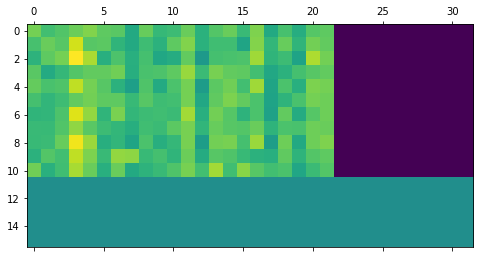

In [ ]:
# check stored attention matrix
torch.manual_seed(842)
bs = 4
sl = 16
csl = sl + 16
d = 64
x = torch.rand(bs, sl, d)
context = torch.rand(bs, csl, d)
mask = torch.ones(bs, sl)
mask[:, -5:] = 0
context_mask = torch.ones(bs, csl)
context_mask[:, -10:] = 0
mask, context_mask = mask.bool(), context_mask.bool()
attn = Attention(d, store_attention=True)
out = attn(x, context, mask=mask, context_mask=context_mask)
attention = attn.attn.attention
assert (bs, sl, d) == out.size()
assert attention.size() == (bs, attn.attn.n_heads, sl, csl)
# zeros for masked keys and "don't cares" for masked queries
plt.matshow(attention[0,0]);

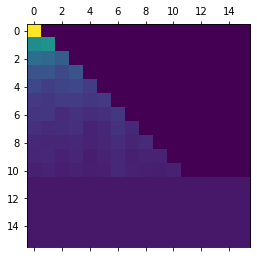

In [ ]:
#hide
#skip
# check stored attention matrix
torch.manual_seed(842)
bs = 4
sl = 16
d = 64
x = torch.rand(bs, sl, d)
mask = torch.ones(bs, sl)
mask[:, -5:] = 0
mask = mask.bool()
attn = Attention(d, store_attention=True, causal=True)
out = attn(x, mask=mask)
attention = attn.attn.attention
assert (bs, sl, d) == out.size()
assert attention.size() == (bs, attn.attn.n_heads, sl, sl)
# zeros for masked keys and "don't cares" for masked queries
plt.matshow(attention[0,0]);

In [ ]:
#hide
from nbdev.export import notebook2script; notebook2script()

Converted 00_core.ipynb.
Converted 01_layers.ipynb.
Converted 02_attention.ipynb.
Converted 03_transformer.ipynb.
Converted 04_reformer.ipynb.
Converted 05_tokenizers.ipynb.
Converted 06_data.ipynb.
Converted 07_metrics.ipynb.
Converted 08_optimizers.ipynb.
Converted 09_tracking.ipynb.
Converted 10_config.ipynb.
Converted index.ipynb.
